In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import datapane as dp
import plotly.graph_objs as go

In [3]:
## to generate random curves
def random_noise(mu,sigma,start_price):
    returns = np.random.normal(loc=mu, scale=sigma, size=365)
    price = start_price*(1+returns).cumprod()
    plt.plot(price)
    return price

In [4]:
def get_data(csv_filename,json_filename,params_filename):
    ## imports test dataset & solar-panel info file
    daily_data = pd.read_csv(csv_filename)
    solar = open(json_filename)
    solar = json.load(solar)
    params = open(params_filename)
    params = json.load(params)

    return [daily_data,solar,params]

In [5]:
loader = get_data('amsterdam_data.csv','panels.json','params.json')
daily_data, solar, params = loader[0], loader[1], loader[2]

In [6]:
solar = solar['small panel']

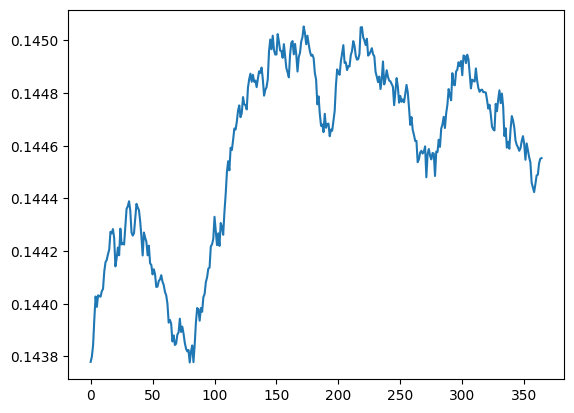

In [7]:
## generate price & mean for algo decisions
np.random.seed(params['algo']['random_seed'])

price_per_kwh = random_noise(params['price']['mu'],params['price']['sigma'],params['price']['start'])

price_mean = pd.Series(price_per_kwh).rolling(window=params['algo']['rolling_window']).mean()
price_mean = price_mean.fillna(price_per_kwh[0:(params['algo']['rolling_window'])].mean())
price_mean = price_mean.tolist()

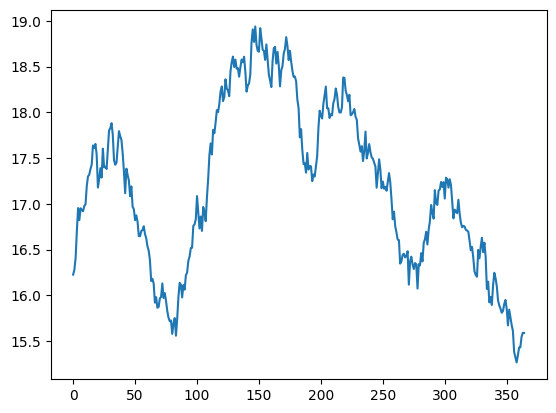

In [8]:
# A demand curve 16 is the starting point representing aggregate demand. We could easily add four demand schedules together to produce this with more accuracy
np.random.seed(params['algo']['random_seed'])
demand_curve = random_noise(params['demand']['mu'],params['demand']['sigma'],params['demand']['start'])

In [9]:
## calculates KwH per day produced based on params
## FOUR HOMES
NUM_SOLAR = params['test_case']['num_solar']
SOLAR_TYPE = solar
## MAX SOLAR INPUT
max = (SOLAR_TYPE['Wattage']*NUM_SOLAR)/1000
## SOLAR PRODUCTION 'TRUE'
solar_production = daily_data['Irradiance']*(SOLAR_TYPE['Area']*NUM_SOLAR)*SOLAR_TYPE['Efficiency']
solar_production_cleaned = []
## Cleans solar since it is usually >> than max prod
for value in solar_production:
    if value > max:
        solar_production_cleaned.append(max)
    else:
        solar_production_cleaned.append(value)

## all the algo reads is the surplus_energy timeseries
demand = demand_curve
surplus_energy = [(float(solar_production_cleaned[i])-float(demand[i])) for i in range(0,len(solar_production_cleaned)-1)]
surplus_energy_cs = pd.Series(surplus_energy).cumsum()

In [10]:
## Algo Time !!

## c limiter is the lowest the battery can reach
critical_limiter = params['algo']['critical_limiter']
## in kwh
battery_capacity = params['test_case']['battery_capacity']
## if we want to start with a charged battery just change 0 -> 42
battery_wattage = [params['algo']['battery_start']]
## arrays
b_supply, g_supply = [], []
cost, sell = [], []
battery_wattage_cs = []


for i in range(0,len(demand)):

    # cummulative sum gives us battery fill state // overhead is kwh left
    battery_wattage_cs = pd.Series(battery_wattage).cumsum()
    overhead = battery_capacity - int(battery_wattage_cs[-1:])
    
    ## if we have a surplus at Time = i
    if surplus_energy[i] < 0:
        
        sell.append(0)
        ## FIND ENERGY
        
        ## If we have more than 70% in the battery use it 
        if float(battery_wattage_cs[-1:]) > (battery_capacity*critical_limiter):
            
            ## fill defecit with 40% battery and 60% grid supply
            g_supply.append(-surplus_energy[i]*params['algo']['defecit_fill_grid'])
            
            battery_wattage.append(surplus_energy[i]*params['algo']['defecit_fill_battery'])
            b_supply.append(-surplus_energy[i]*params['algo']['defecit_fill_battery'])

            ## if prices are low then buy 20% of the battery energy served to recharge it
            if price_per_kwh[i] < (price_mean[i]*params['algo']['battery_refil_price_multiple']):
                
                add_sup = b_supply[i]*params['algo']['battery_refil_multiple']
                b_supply[i] = b_supply[i] - add_sup
                battery_wattage[i] = battery_wattage[i] + add_sup
                g_supply[i] = g_supply[i] + add_sup
                cost.append(g_supply[i]*price_per_kwh[i])
            else:
                cost.append(g_supply[i]*price_per_kwh[i])
            
            
        
        ## if not more than 70% in battery
        else:
            
            b_supply.append(0)
            ## if battery under 70% then charge it with 1Kwh that day from the grid + the surplus added
            if overhead > 0:
                battery_wattage.append(params['algo']['daily_battery_charge'])
                g_supply.append(-surplus_energy[i]+params['algo']['daily_battery_charge'])
                cost.append((-surplus_energy[i]+params['algo']['daily_battery_charge'])*price_per_kwh[i])
            ## if battery at 100% and not discharging (special case, limiter = 1) then buy from grid & don't chrage battery
            else:
                g_supply.append(-surplus_energy[i])
                cost.append((-surplus_energy[i])*price_per_kwh[i])
           
            

    ## if we have a surplus
    elif surplus_energy[i] > 0:
        
        cost.append(0)
        b_supply.append(0)
        g_supply.append(0)

        ## SELL OR STORE
        ## If energy is cheap/expensive then store
        if price_per_kwh[i] > price_mean[i]:
            
            #print(overhead)
            # if you can store
            if overhead > 0:
                battery_wattage.append(surplus_energy[i])
                sell.append(0)
            else:
                sell.append(surplus_energy[i]*price_per_kwh[i])
                battery_wattage.append(0)
                
        else:
            ## sell
            sell.append(surplus_energy[i]*price_per_kwh[i])
            battery_wattage.append(0)

In [11]:
data_frame = pd.DataFrame()
data_frame.insert(0,'Household Demand',demand)
data_frame.insert(1,'Solar Supply',solar_production_cleaned[:365])
data_frame.insert(2,'Grid Supply',g_supply)
data_frame.insert(3,'Battery',b_supply)
data_frame.insert(4,'Battery Storage',battery_wattage_cs)
data_frame.insert(5,'Electricity Price',price_per_kwh)
data_frame.insert(6,'Electricity Cost',cost)
data_frame.insert(7,'Electricity Revenue',sell)

In [12]:
demand_obj = (go.Figure(go.Scatter(x=data_frame.index,y=demand,name='Demand')))
demand_obj.update_layout(
                    title={
                        'text': "Daily Household Energy Demand<br><span style='font-size:0.6em;color:gray'>Simulated Daily Demand using random noise generation for 4 homes</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Daily Demand (Kwh)",
                legend_title="",
                     )
print('Done!')

Done!


In [13]:
solar_obj = (go.Figure(go.Scatter(x=data_frame.index,y=solar_production_cleaned,name='Solar Production')))
solar_obj.update_layout(
                    title={
                        'text': "Daily Solar Production<br><span style='font-size:0.6em;color:gray'>Represents our simulation parameters</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Daily Supply (Kwh)",
                legend_title="",
                     )
print('Done!')

Done!


In [14]:
grid_supply = (go.Scatter(x=data_frame.index,y=g_supply,name='Grid Supply'))
solar_supply = (go.Scatter(x=data_frame.index,y=solar_production_cleaned,name='Solar Supply'))
battery_supply = (go.Scatter(x=data_frame.index,y=b_supply,name='Battery Supply'))
supply = go.Figure([grid_supply,solar_supply,battery_supply,go.Scatter(x=data_frame.index,y=demand,name='Demand')])
supply.update_layout(
                    title={
                        'text': "Simulated Supply & Demand Curves<br><span style='font-size:0.6em;color:gray'>Detailed compossition of node supply & demand</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Daily Supply & Demand (Kwh)",
                legend_title="",
                     )
print('Done!')

Done!


In [15]:
price_line = (go.Scatter(x=data_frame.index,y=price_per_kwh,name='Energy Price'))
mean_line = (go.Scatter(x=data_frame.index,y=price_mean,name='Energy Price 15-D Rolling Mean'))
price_obj = go.Figure([price_line,mean_line])
price_obj.update_layout(
                    title={
                        'text': "Simulated Daily Energy Price<br><span style='font-size:0.6em;color:gray'>Random noise generated, demand-correlated price timeseries</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Price ($)",
                legend_title="",
                     )
print('Done!')

Done!


In [16]:
battery_line = (go.Scatter(x=data_frame.index,y=b_supply,name='Battery Energy Use'))
wattage_line = (go.Scatter(x=data_frame.index,y=battery_wattage_cs,name='Battery Stored Wattage'))
limiter_line = (go.Scatter(x=data_frame.index,y=[24.9 for i in range(0,366)],name='Battery Discharge Limit'))
battery_obj = go.Figure([battery_line,wattage_line,limiter_line])
battery_obj.update_layout(
                    title={
                        'text': "Simulated Battery Charge & Discharge<br><span style='font-size:0.6em;color:gray'>Showcasing battery use patterns based on our optimization algo</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Daily Store & Use (Kwh)",
                legend_title="",
                     )
print('Done!')

Done!


In [17]:
cost_line = (go.Scatter(x=data_frame.index,y=pd.Series(cost).cumsum(),name='Energy Purchase Cost'))
revenue_line = (go.Scatter(x=data_frame.index,y=pd.Series(sell).cumsum(),name='Energy Sale Revenue'))
net_line = (go.Scatter(x=data_frame.index,y=pd.Series(([cost[i]-sell[i] for i in range(0,len(cost))])).cumsum(),name='Net Cost/Profit'))
market_obj = go.Figure([cost_line,revenue_line,net_line])
market_obj.update_layout(
                    title={
                        'text': "Simulated Energy Cost & Revenue<br><span style='font-size:0.6em;color:gray'>Showcases the energy cost and sales over the period</span>",
                        'x':0.5,
                        'y':0.90,
                        'xanchor': 'center',
                        'font':{'size':26}},
                        xaxis_title="Time (Days)",
                yaxis_title="Cost & Revenue ($)",
                legend_title="",
                     )
print('Done!')

Done!


In [18]:
energy_profile = [pd.Series(g_supply).sum(),pd.Series(b_supply).sum(),pd.Series(solar_production_cleaned).sum()]
energy_profile = [energy_profile[i]/sum(energy_profile) for i in range(0,len(energy_profile))]


weights_pie = go.Figure(go.Pie(values=energy_profile,labels=['Grid','Battery','Solar'],hoverinfo = 'label+value'))
weights_pie.update_layout(
    title={
            'text': "Total Energy Supply Breakdown<br><span style='font-size:0.8em;color:gray'></span>",
            'x':0.5,
            'y':0.90,
            'xanchor': 'center',
            'font':{'size':26}},
    legend_title="Energy Sources",
    )
print('Done!')

Done!


In [19]:
for fig_tmp in [demand_obj,solar_obj,supply,battery_obj,market_obj,price_obj]:
    fig_tmp.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=True
            ),
            type="linear"
        ))

In [21]:
#dp.login(token=params['datapane']['token'])
dp.Report(
    dp.Group(
        dp.Group(
            dp.Media(file='header.png'),
            dp.Text(
                """# Energy Flow Optimization Simulation
## Hack from Home 2021

The P2P Energy Exchange is aiming to revolutionize and democratize energy markets. Our innovative platform integrates individual nodes (households, producers, buildings or, regions) into a decentralized energy market. To deploy our decentralization system, we are offering automated intra-node energy flow optimization. This demo is a proof of concept for this said optimization. We use proprietary algorithms and Machine Learning (ML) to best allocate energy resources within a given context. You can find more on our website: https://hackathon-from-sfsdf.vercel.app/

In this demo we are simulating a 4 home complex, located in Amsterdam, with 64 250W panels totalling 115m^2, there is also a 43Kwh Battery pack and, a grid connection. We assume a baseline consumption of 4Kwh per home. To simulate solar energy yield we use NASA’s POWER API to find historic irradiance data. 

*The Graphs are interactive.*
            """),
            columns=2,
        ),    
        dp.Group(
            dp.Plot(demand_obj),
            dp.Text("""
            We simulated our demand curve (left) using our base assumption of 4Kwh per home (16Kwh in total). The timeseries was generated using random noise to allow variance and ensure that our system can work on undefined interval data. Energy Demand is one of the three main real-time inputs, the other being solar production and energy price. In this test-case we assume consumption priority for the generated energy, and then use the battery or gird as needed. 
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(solar_obj),
            dp.Text("""
            This is simulated Daily Solar production given 1 year historical data for Amsterdam via NASA’s POWER API. Our simulation parameters are 64 250W panels, 1.6m^2 each, totalling 115m^2, giving us a maximum generation potential of 18 Kwh per day at 15% efficiency. Noting that we can easily change simulation parameters and load custom solar-generation profiles. We can also see that the solar production peaks out soon and remains constant, this is because panels are low efficiency.
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(supply),
            dp.Text("""
            On the left we can see the complete composition of the supply & demand pattern during the year. Our system has one demand curve (which can be thought of as an aggregate) and three supply curves. The house gets energy from solar, grid and, battery, only sourcing from the latter two if solar production is at a deficit. Here we can see how the system responds against the supply impacts. We can easily make out when and why energy from other sources was needed. The choice to source from one or the other is handled by our proprietary algorithm. 
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(price_obj),
            dp.Text("""
            This is a simulated daily price for 1Kwh of energy, using c14.3 as a starting point and adding noise. Currently we are using the Rolling Mean to have an idea of relative prices and make optimal buying/selling decisions. Ideally our system would differentiate between energy sources and therefore, will be able to source energy based on its carbon footprint. We have capabilities to add two price-curves but used one in this simulation for simplicity.
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(battery_obj),
            dp.Text("""
            The household battery pack was by far the most fun to model. According to our set parameters we have 42Kwh battery, which we have set a discharge limit at 70% of capacity. In the graph we can clearly see how well it has performed remaining above the boundary. What is notable is that the big increase in wattage before Day 100 is due to the really cheap prices. Money which was saved by discharging the battery little by little, since the price went up again. 
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(market_obj),
            dp.Text("""
            Here we can see the cumulative energy cost and revenue. This represents the total energy bought from the grid and that sold. We can see that the system has been very economical and considerably lowered (by half!) the total electricity bill during the summer. Of course, the skyrocketing on the right is winter where solar isn't the best especially in Amsterdam (exact reason to choose it), this can be mitigate by introducing secondary renewable flows like biothermal, wind or others. 
            """),
            columns = 2,
        ),
        dp.Group(
            dp.Plot(weights_pie),
            dp.Text("""
            On the left we can see the total energy supply breakdown. Clear winner here is solar which was used 87% of the time. Of course, second is the grid at 12% and finally, the battery at 1.2%. This chart tells us we are the right direction, we have used a lot of solar, but we can also tell there is much optimization to be done.
            """),
            columns = 2,
        ), 
        dp.Group(
            dp.Text("""
            ## Acknowledgments & Citations

This simulation was produced for Hack from Home 2021, organized by Dataswift, using Python 3.8 on Datalore and Visual Studio Code. This report was generated using Datapane.

*Source code by:* Foivos Dimitrakopoulos

### Data Sources

NASA POWER API: https://power.larc.nasa.gov/

Preliminary Energy Info: https://www.greenmatch.co.uk/blog/how-many-solar-panels-do-i-need#:~:text=A%204kW%20solar%20system%20is,solar%20panels%20you%20will%20use. 

### Citations
Kubli, M., Loock, M. and Wüstenhagen, R., 2018. The flexible prosumer: Measuring the willingness to co-create distributed flexibility. Energy Policy, [online] 114, pp.540-548. Available at: https://doi.org/10.1016/j.enpol.2017.12.044 [Accessed 17 May 2021].

Ghofrani, M. and Alolayan, M., 2018. Time Series and Renewable Energy Forecasting. Time Series Analysis and Applications, [online] Available at: http://10.5772/intechopen.70845 [Accessed 17 May 2021].

Gartner, 2020. Maverick* Research: The New Energy Markets Under Your Kitchen Sink. Gartner.
            """)
        ),
        columns=1),
).save(path=f"data/{params['datapane']['name']}.html")

TypeError: Group.__init__() got an unexpected keyword argument 'rows'